<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

# Data import and processing

In [1]:
# import some useful packages for this analysis
from setup import *

In [2]:
# read in the main datafile
json_file = json.load(open('../data/keplergl.json'))

## Converting the json file

Unforuntately, the json file can't be read directly into a GeoDataFrame using geopandas, because it contains five different datasets, and because the individual datasets' structure was not recognised by geopandas. Therefore, I had to implement a manual conversion of the json file into five dataframes, holding the individual layers.

The hazard data is in the first dataset, which I save in df1. The remaining dfs hold the shapes of the fires. 

In [3]:
# Initialise pandas dfs to hold the datasets
df1, df2, df3, df4, df5 = pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
dfs = [df1, df2, df3, df4, df5]

# Create a df for each dataset in turn
for dataset in range(5):
    
    # get actual data from json
    data = json_file['datasets'][dataset]['data']['allData']
    
    # turn into df
    dfs[dataset] = pd.DataFrame(data)
    
    # extract coordinates
    dfs[dataset].loc[:,'geometry'] = dfs[dataset][0].map(lambda x: x['geometry']['coordinates'][0])
    
    # create polygons in list
    if json_file['datasets'][dataset]['data']['allData'][0][0]['geometry']['type'] == 'Polygon':
        rows = dfs[dataset].geometry.to_list()    
        geometry = [Polygon(xy) for xy in rows]
        
        # drop columns we don't need
        dfs[dataset] = dfs[dataset].iloc[:,1:3]
    
        # rename columns
        dfs[dataset].columns = ['date', 'level']
        dfs[dataset].date = pd.to_datetime(dfs[dataset].date)
        
    # create geometry column based on structure of the individual datasets
    elif json_file['datasets'][dataset]['data']['allData'][0][0]['geometry']['type'] == 'MultiPolygon':
        rows = dfs[dataset].geometry[0]
        if len(rows) > 1:
            polygons = []
            for row in rows:
                polygons.append(Polygon(row))
            geometry = [MultiPolygon(polygons)]
            
        else: 
            geometry = [Polygon(xy) for xy in rows] 


    
    # Set crs
    crs = {'init': 'epsg:4326'}

    # Create GDF
    dfs[dataset] = gpd.GeoDataFrame(dfs[dataset], crs=crs, geometry=geometry)

## Inspecting the data

I begin my inspection with the main dataset that's in df1. It looks like we have 511870 pixel-time datapoints with a fire hazard index score. However, there seem to be some pixel-time points which we have to discard, because they have negative index values, which doesn't make sense. 

In [4]:
main_df = dfs[0]
main_df

,date,level,geometry
0,2019-10-01,1,"POLYGON ((-121.06779 42.05171, -121.06779 42.0..."
1,2019-10-01,1,"POLYGON ((-121.09860 42.04144, -121.09860 42.0..."
2,2019-10-01,3,"POLYGON ((-121.08833 42.04144, -121.08833 42.0..."
3,2019-10-01,4,"POLYGON ((-121.07806 42.04144, -121.07806 42.0..."
4,2019-10-01,2,"POLYGON ((-121.03699 42.04144, -121.03699 42.0..."
...,...,...,...
518865,2019-10-08,4,"POLYGON ((-119.17861 36.91807, -119.17861 36.9..."
518866,2019-10-08,3,"POLYGON ((-119.16835 36.91807, -119.16835 36.9..."
518867,2019-10-08,2,"POLYGON ((-119.15808 36.91807, -119.15808 36.9..."
518868,2019-10-08,1,"POLYGON ((-119.33262 36.90780, -119.33262 36.8..."


It looks like the index goes from 0 to 999.

In [5]:
main_df.describe()

,level
count,"518,870"
mean,41
std,"1,300"
min,"-32,767"
25%,12
50%,41
75%,112
max,989


Let's discard the datapoints which have incorrect index values.

In [6]:
main_df[main_df.level < 0]

,date,level,geometry
1283,2019-10-01,-32767,"POLYGON ((-121.10886 41.90797, -121.10886 41.8..."
1420,2019-10-01,-32767,"POLYGON ((-121.20127 41.88744, -121.20127 41.8..."
2132,2019-10-01,-32767,"POLYGON ((-122.59762 41.83610, -122.59762 41.8..."
3517,2019-10-01,-32767,"POLYGON ((-122.47441 41.77450, -122.47441 41.7..."
3862,2019-10-01,-32767,"POLYGON ((-122.25880 41.73343, -122.25880 41.7..."
...,...,...,...
516359,2019-10-08,-32767,"POLYGON ((-119.71251 37.21582, -119.71251 37.2..."
517515,2019-10-08,-32767,"POLYGON ((-121.13967 37.08235, -121.13967 37.0..."
517543,2019-10-08,-32767,"POLYGON ((-121.75570 37.07208, -121.75570 37.0..."
518203,2019-10-08,-32767,"POLYGON ((-121.68383 36.98994, -121.68383 36.9..."


In [7]:
main_df = main_df[main_df.level > 0]

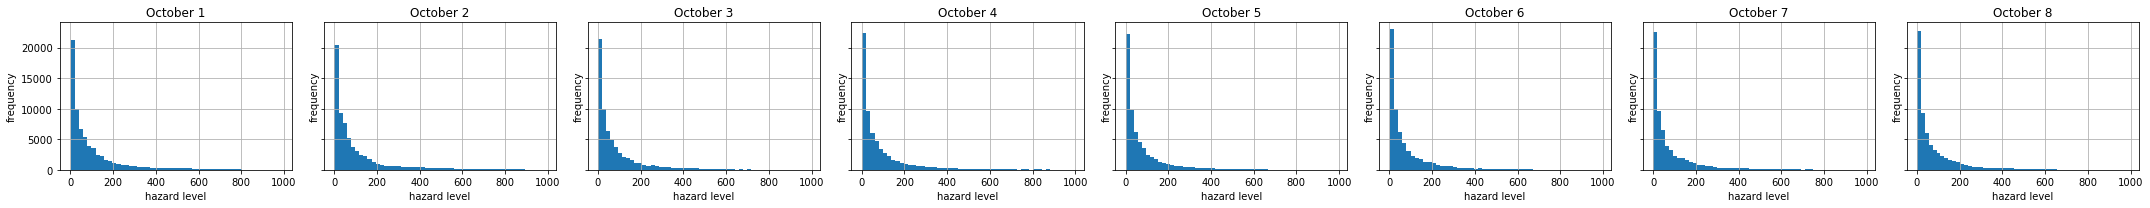

In [8]:
# Set up frame
fig, axes = plt.subplots(nrows=1,ncols=8, figsize = (30, 3), sharex=True, sharey=True)
fig.subplots_adjust(hspace = 0.4)

for day in range(1,9,1):
    main_df[main_df.date == dt.datetime(2019, 10, day)].hist(bins = 50, ax = axes[day-1])
    axes[day-1].set(title = 'October ' + str(day), ylabel = 'frequency', xlabel = 'hazard level')

plt.tight_layout();
plt.show()

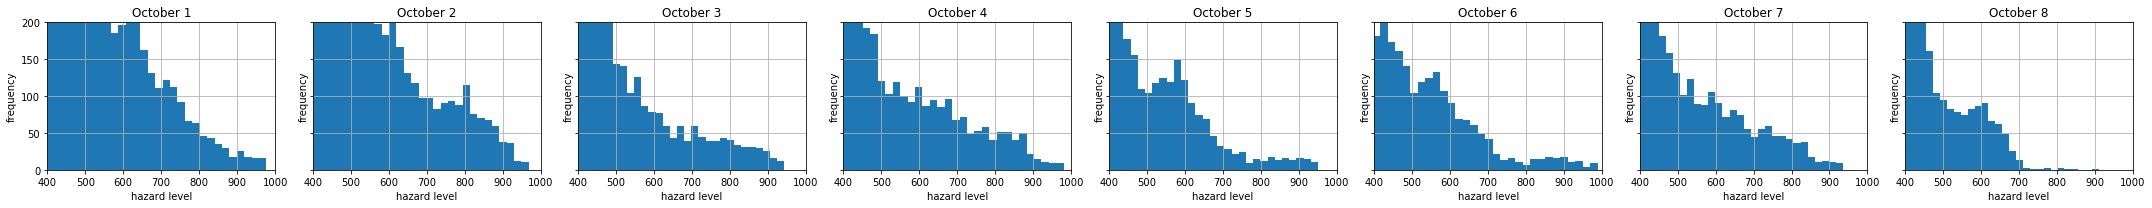

In [9]:
# Set up frame
fig, axes = plt.subplots(nrows=1,ncols=8, figsize = (30, 3), sharex=True, sharey=True)
fig.subplots_adjust(hspace = 0.4)

for day in range(1,9,1):
    main_df[main_df.date == dt.datetime(2019, 10, day)].hist(bins = 50, ax = axes[day-1])
    axes[day-1].set(title = 'October ' + str(day), ylabel = 'frequency', xlabel = 'hazard level')

axes[0].set_xlim(400, 1000); axes[0].set_ylim(0, 200);
plt.tight_layout();
plt.show()

## Pick area of interest

I will use one of the fire areas for this.

In [10]:
fire_area = dfs[1].loc[:,['geometry']]
fire_area

,geometry
0,"POLYGON ((-122.75937 38.52304, -122.75925 38.5..."


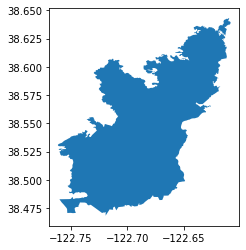

In [11]:
fire_area.plot()

In [12]:
fire_centre = fire_area.centroid

In [13]:
xy = (fire_centre[0].xy[0][0], fire_centre[0].xy[1][0])
xy

(-122.68515427508606, 38.54696115613171)

In [15]:
focus_area_boundary = fire_centre.buffer(0.5).envelope[0]

## Import additional data

In [ ]:
roads = ox.graph_from_polygon(focus_area_boundary, network_type='drive_service')
fig, ax = ox.plot_graph(roads)

In [114]:
nodes, edges = ox.graph_to_gdfs(roads)

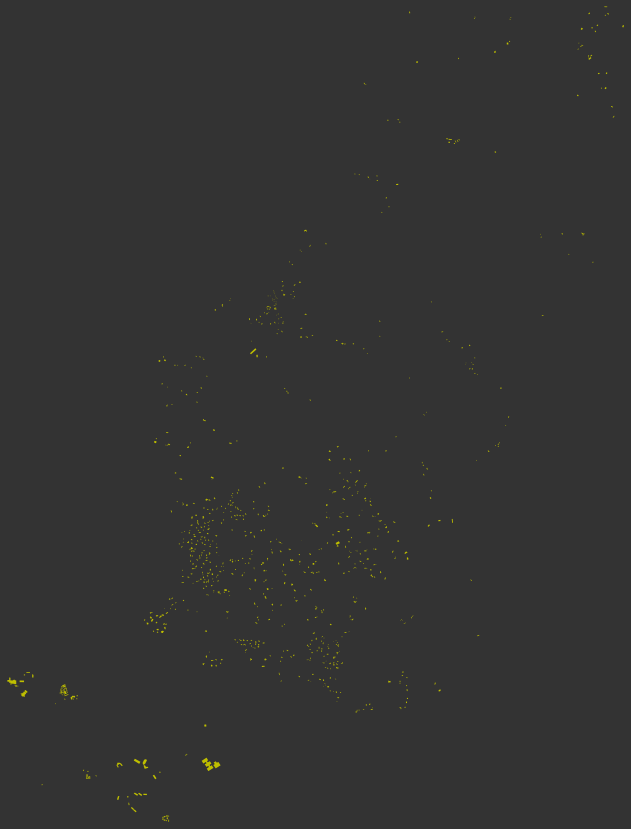

In [123]:
buildings = ox.footprints.footprints_from_polygon(focus_area_boundary)
buildings_proj = ox.project_gdf(buildings)
fig, ax = ox.footprints.plot_footprints(buildings_proj, bgcolor='#333333', color='y', figsize = (15, 15))

In [100]:
areas = buildings_proj.area
areas.head()

41277766    1,804
41410040      517
134253006     365
288601478     244
288601479     475
dtype: float64

In [115]:
poi = ox.pois.create_poi_gdf(polygon=focus_area_boundary)
poi[(poi.amenity != 'parking') & (poi.amenity.notna())].head()

,osmid,geometry,amenity,ele,gnis:county_id,gnis:created,gnis:feature_id,gnis:state_id,name,element_type,religion,addr:state,gnis:county_name,gnis:import_uuid,gnis:reviewed,source,emergency,parking,addr:city,addr:housenumber,addr:postcode,addr:street,operator,brand,brand:wikidata,brand:wikipedia,phone,website,name:en,denomination,cuisine,opening_hours,takeaway,highway,natural,backrest,colour,material,seats,waste,nodes,wikidata,healthcare,building,capacity,fee,access,surface,beds,healthcare:speciality
358760854,358760854,POINT (-122.64415 38.50547),school,221,097,01/19/1981,218172,06,Alpine School,node,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
358831353,358831353,POINT (-122.75999 38.51435),school,52,097,07/20/1998,1799272,06,San Miguel Elementary School,node,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
358831426,358831426,POINT (-122.70054 38.47269),school,86,097,07/20/1998,1799353,06,Hidden Valley Elementary School,node,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
358831470,358831470,POINT (-122.67539 38.48333),school,78,097,07/20/1998,1799388,06,Rincon Valley Christian School,node,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
358831571,358831571,POINT (-122.74915 38.49324),place_of_worship,48,097,07/20/1998,1799503,06,Calvary Chapel Fellowship Church,node,christian,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


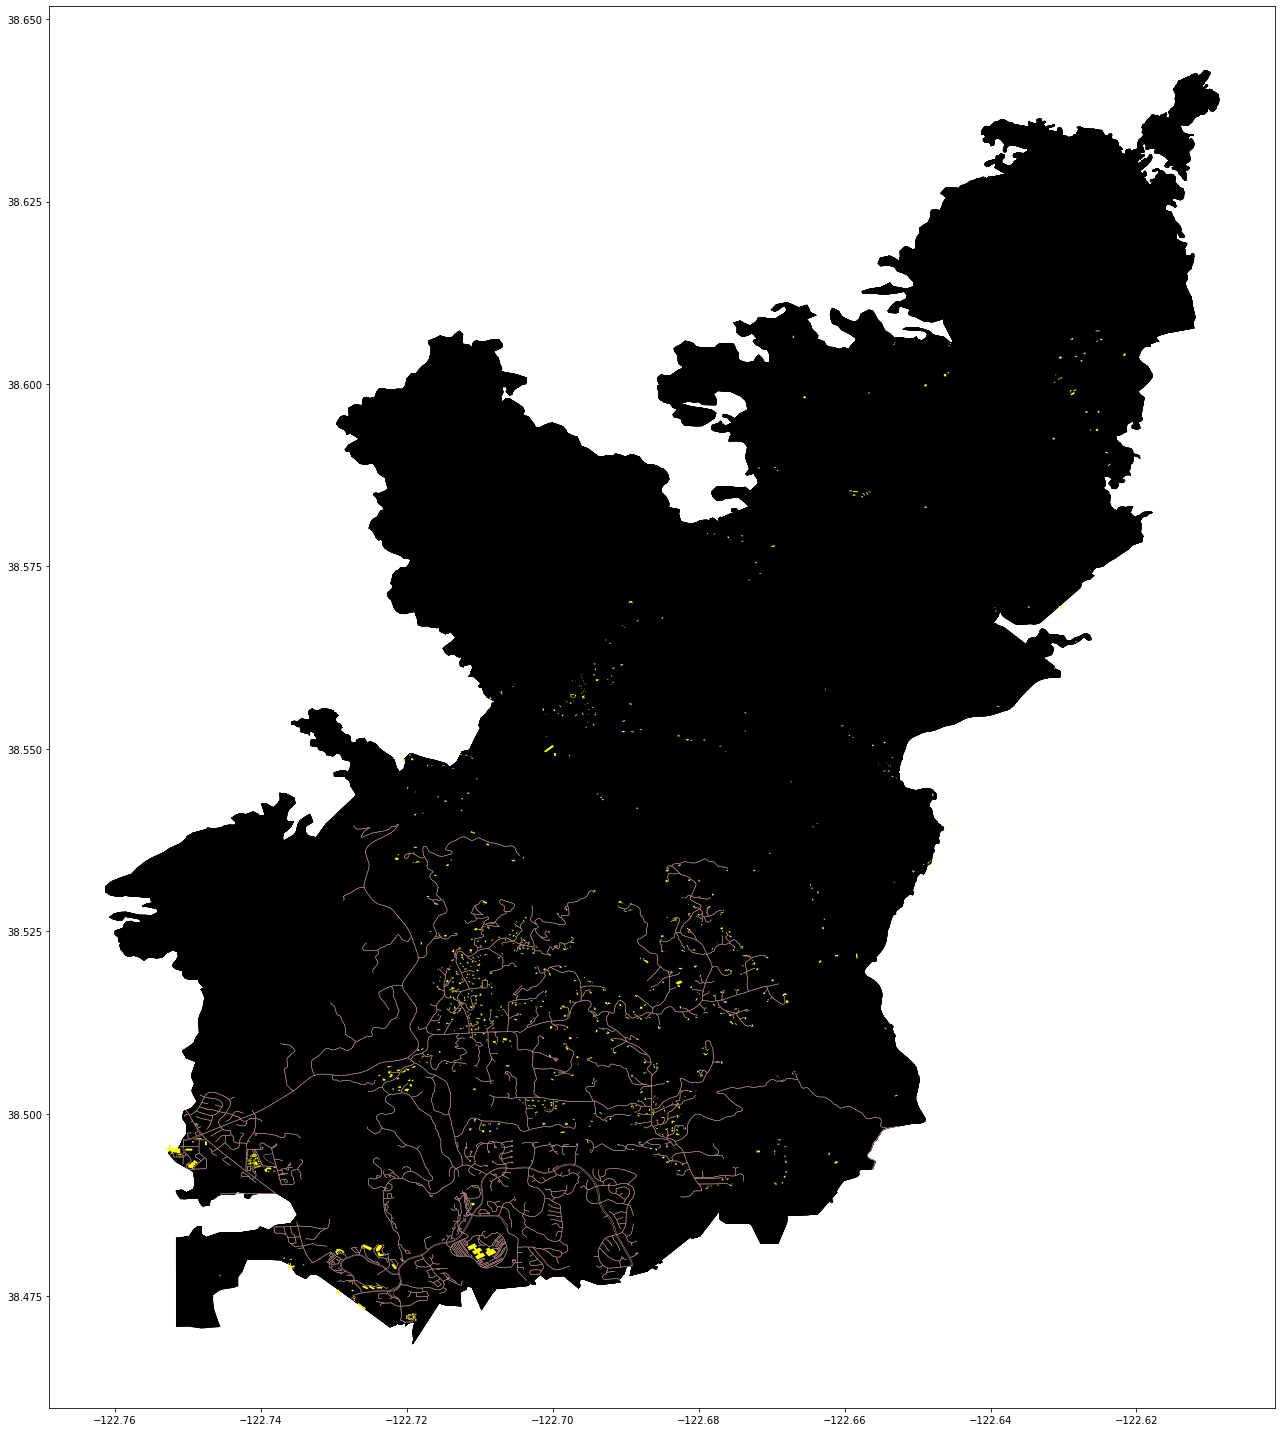

In [128]:
# Plot the footprint
fig, ax  = plt.subplots(figsize = (20, 20))

focus_area.plot(ax =ax, facecolor='black')

# Plot street edges
edges.plot(ax=ax, linewidth=0.5, edgecolor='#BC8F8F')

# Plot buildings
buildings.plot(ax=ax, facecolor='yellow', alpha=1)

# Plot restaurants
# poi.plot(ax=ax, color='green', alpha=0.7, markersize=10)

plt.tight_layout()

In [101]:
ox.plot.plot_graph_folium(roads)